### Further Hypothesis Testing

In [1]:
# Select this cell and type Ctrl-Enter to execute the code below.

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

data = pd.read_csv("stars.csv")
type_key = ['Brown Dwarf', 'Red Dwarf', 'White Dwarf', 'Main Sequence', 'Supergiant','Hypergiant']


## 5 - Comparing distributions over a categorical variable

Your undergraduate project student, Tunde, is looking at the distributions of spectral class (i.e. colour) for various types of star. 

He says that the bar charts for white dwarves (type 2) and main sequence stars (type 3) seem similar, but you are not so sure. 


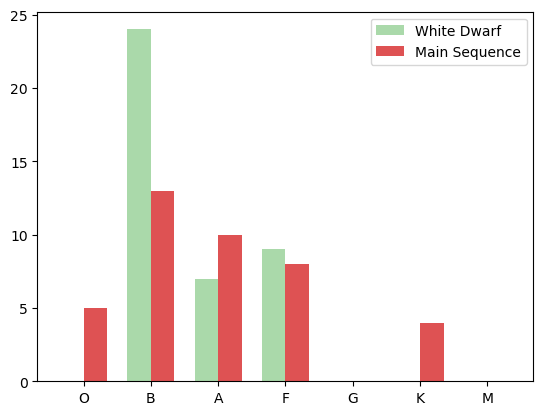

In [3]:
labels = ['O','B','A','F','G','K','M']

grouped = data.groupby(data.type)

classes2 = grouped.get_group(2).spectral_class.value_counts()
classes3 = grouped.get_group(3).spectral_class.value_counts()

for i in labels:
    if (i not in classes2):
        classes2[i] = 0 
    if (i not in classes3):
        classes3[i] = 0 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [classes2[i] for i in labels], width, alpha=0.4, color = 'C2', label=type_key[2])
rects2 = ax.bar(x + width/2, [classes3[i] for i in labels], width, alpha=0.8, color = 'C3', label=type_key[3])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

plt.show()


### Question: do types 2 and 3 share the same distribution of spectral class?

To test differences in distributions over a *categorical variable* like spectral class, we can use [*Pearson's chi-squared test*](https://en.wikipedia.org/wiki/Chi-squared_test):

### Chi-squared test for statistical independence

#### Theory

$H_0$: Probability distribution for the categorical variable (e.g. spectral class) is independent of group (e.g. star type).

$H_1$: Probability distribution depends on group.

We need to find out whether the differences in observed frequencies between the two groups are small enough to have arisen by chance. We do this by constructing a [*contingency table*](https://en.wikipedia.org/wiki/Contingency_table) showing the observed frequency of each outcome for each of the two groups, and comparing to the *expected frequencies* under $H_0$.


The test statistic is

$$X^2 = \sum^k_{i=1}{\frac{(x_i-m_i)^2}{m_i}}$$,

where $k$ is the number of cells in the table and $x_i$ and $m_i$ are the observed and expected frequencies for each cell.

Under $H_0$, $X^2$ follows a [$\chi^2$ distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution), which is parametrised by the number of degrees of freedom. A contingency table of size $a \times b$ has $(a-1)(b-1)$ degrees of freedom, i.e. the number of independent counts when row and column sums are held fixed.

#### Assumptions

- Sampling is random
- Each sample is independent of the others
- Expected frequency for each cell must be sufficiently large

The approximation to the $\chi^2$ distribution breaks down if expected frequencies are too low. It will normally be acceptable so long as no more than 20% of the events have expected frequencies below 5. Where there is only 1 degree of freedom (i.e. a 2 $\times$ 2 table), the approximation is not reliable if expected frequencies fall below 10. 


#### Application

We will set $\alpha=0.05$.

We begin by making a contingency table for the observed spectral classes.

In [4]:
# OBSERVED

types = [2,3]
subset = pd.concat([grouped.get_group(t) for t in types])

obs = pd.crosstab(subset.type,subset.spectral_class,margins=True,margins_name="total")
print("OBSERVED:")
obs

OBSERVED:


spectral_class,A,B,F,K,O,total
type,,,,,,
2,7,24,9,0,0,40
3,10,13,8,4,5,40
total,17,37,17,4,5,80


In [5]:
stats.chi2_contingency(obs)

Chi2ContingencyResult(statistic=12.858505564387915, pvalue=0.23169090100267423, dof=10, expected_freq=array([[ 8.5, 18.5,  8.5,  2. ,  2.5, 40. ],
       [ 8.5, 18.5,  8.5,  2. ,  2.5, 40. ],
       [17. , 37. , 17. ,  4. ,  5. , 80. ]]))

From the row and column totals, we can calculate the *expected* frequencies under $H_0$:

In [6]:
# EXPECTED

exp = pd.DataFrame(stats.contingency.expected_freq(obs))
exp.columns = obs.columns
exp = exp.rename(index={0:2,1:3,2:"total"})
exp = exp.rename_axis(columns=obs.axes[1].name,index=obs.axes[0].name)
print("EXPECTED:")
exp

EXPECTED:


spectral_class,A,B,F,K,O,total
type,,,,,,
2,8.5,18.5,8.5,2.0,2.5,40.0
3,8.5,18.5,8.5,2.0,2.5,40.0
total,17.0,37.0,17.0,4.0,5.0,80.0


The expected values for classes K and O are too small. We can combine the last three columns to get all of the expected values over 5:

In [7]:
# OBSERVED (combining columns)

new_obs = obs[['A','B']][:-1]
new_obs['others'] = obs[['F','K','O']][:-1].sum(axis=1)
print("OBSERVED:")
new_obs

OBSERVED:


spectral_class,A,B,others
type,,,
2,7,24,9
3,10,13,17


In [8]:
# EXPECTED (combining columns)

new_exp = pd.DataFrame(stats.contingency.expected_freq(new_obs))
new_exp.columns = new_obs.columns
new_exp = new_exp.rename(index={0:2,1:3})
new_exp = new_exp.rename_axis(columns=new_obs.axes[1].name,index=new_obs.axes[0].name)
print("EXPECTED:")
new_exp

EXPECTED:


spectral_class,A,B,others
type,,,
2,8.5,18.5,13.0
3,8.5,18.5,13.0


In `scipy.stats`, he most convenient form of the chi-squared test for a contingency table is `chi2_contingency`, which just takes the table of observations as input and calculates the expected values and degrees of freedom accordingly.

In [9]:
p_value = stats.chi2_contingency(new_obs)[1]
p_value

0.043691126681826536

According to the chi-squared test, $p<\alpha$, so there is enough evidence to reject $H_0$:
it appears that white dwarves and main sequence stars follow different distributions for spectral class.

<br>